# Data Poisoning in Credit Scoring Models with Anomaly Detection
## Manav Patel - 500967756
## EE8227 Project

## Base XGBoost, Random Forest, and VotingClassifier

In [ ]:

import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from data_preprocessing import load_data, preprocess_data, split_data
from model_training import initialize_models, train_and_evaluate
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

sys.path.append('./src') 


In [ ]:
# preprocess

data_file_path = Path('./data/german_credit_data.csv') 

if not data_file_path.exists():
    print(f"Dataset not found at {data_file_path}. Please ensure the file is placed in the 'data/' directory.")
else:
    # Load the dataset
    data = load_data(data_file_path)
    print("Dataset Loaded Successfully.")
    print(f"Dataset Shape: {data.shape}")
    display(data.head())
    
    # Preprocess the dataset
    X_selected, y_encoded, preprocessor, selected_feature_names = preprocess_data(data, target_column='class')
    print("\nData Preprocessing Completed.")
    print(f"Processed Feature Matrix Shape: {X_selected.shape}")
    print(f"Encoded Target Vector Shape: {y_encoded.shape}")
    
    # Split the data into training, validation, and testing sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_selected, y_encoded, test_size=0.3, random_state=42)
    print("\nData Splitting Completed.")
    print(f"Training Set: {X_train.shape}, {y_train.shape}")
    print(f"Validation Set: {X_val.shape}, {y_val.shape}")
    print(f"Testing Set: {X_test.shape}, {y_test.shape}")


Dataset Loaded Successfully.
Dataset Shape: (1000, 21)


,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Class
0,... < 0 DM,6,critical account / other credits existing (not...,radio/television,1169,NaN,.. >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customer's name",yes,Good
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad
2,no checking account,12,critical account / other credits existing (not...,education,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good
3,... < 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/ life insur...,45,none,for free,1,skilled employee / official,2,none,yes,Good
4,... < 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,...,NaN,53,none,for free,2,skilled employee / official,2,none,yes,Bad


Missing Values Summary:
 savings_account_bonds    183
property                 154
dtype: int64
Filled missing values in 'savings_account_bonds' with mode: ... < 100 DM
Filled missing values in 'property' with mode: car or other, not in attribute 6
Split 'personal_status_and_sex' into 'personal_status' and 'sex'

Selected Top 30 Features:
['num__duration_in_month' 'num__credit_amount'
 'num__installment_rate_in_percentage_of_disposable_income'
 'num__age_in_years' 'cat__status_of_existing_checking_account_... < 0 DM'
 'cat__status_of_existing_checking_account_0 <= ... < 200 DM'
 'cat__status_of_existing_checking_account_no checking account'
 'cat__credit_history_all credits at this bank paid back duly'
 'cat__credit_history_critical account / other credits existing (not at this bank)'
 'cat__credit_history_existing credits paid back duly till now'
 'cat__credit_history_no credits taken / all credits paid back duly'
 'cat__purpose_radio/television'
 'cat__savings_account_bonds_.. >= 100

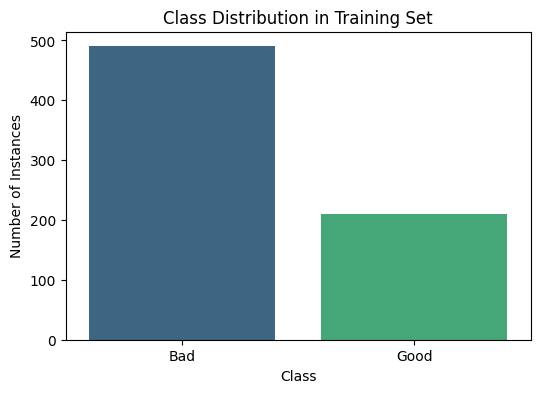

Training Set Class Distribution:
Bad: 210, Good: 490


In [ ]:
# Class Imbalance

# original class distribution
class_counts = pd.Series(y_train).value_counts()
class_labels = ['Bad', 'Good']

plt.figure(figsize=(6,4))
sns.barplot(x=class_labels, y=class_counts.values, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.ylabel('Number of Instances')
plt.xlabel('Class')
plt.show()

print(f"Training Set Class Distribution:\nBad: {class_counts.get(0,0)}, Good: {class_counts.get(1,0)}")


In [ ]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
resampled_class_counts = pd.Series(y_train_resampled).value_counts()
print("Resampled Training Set Class Distribution:")
print(f"Bad: {resampled_class_counts.get(0,0)}, Good: {resampled_class_counts.get(1,0)}")


Resampled Training Set Class Distribution:
Bad: 490, Good: 490


In [ ]:
# Feature Engineering

import numpy as np
import pandas as pd

print("Selected Feature Names before Feature Engineering:", selected_feature_names)

#  Removing Duplicate Features
unique_features, counts = np.unique(selected_feature_names, return_counts=True)
duplicate_features = unique_features[counts > 1]

for feature in duplicate_features:
    indices = np.where(selected_feature_names == feature)[0]
    selected_feature_names = np.delete(selected_feature_names, indices[1:])
    X_selected = np.delete(X_selected, indices[1:], axis=1)
    print(f"Removed duplicate feature: {feature}")

# Creating 'credit_amount_per_month'
try:
    credit_amount_index = list(selected_feature_names).index('num__credit_amount')
    duration_index = list(selected_feature_names).index('num__duration_in_month')
    
    credit_amount_per_month = X_selected[:, credit_amount_index] / (X_selected[:, duration_index] + 1) 
    X_selected = np.hstack([X_selected, credit_amount_per_month.reshape(-1, 1)])
    selected_feature_names = np.append(selected_feature_names, 'credit_amount_per_month')
    print("Added Feature: credit_amount_per_month")
except ValueError as e:
    print(f"Cannot create 'credit_amount_per_month': {e}")

# Creating 'number_of_existing_credits_plus_one'
try:
    number_credits_index = list(selected_feature_names).index('num__number_of_existing_credits_at_this_bank')
    number_of_existing_credits_plus_one = X_selected[:, number_credits_index] + 1
    X_selected = np.hstack([X_selected, number_of_existing_credits_plus_one.reshape(-1, 1)])
    selected_feature_names = np.append(selected_feature_names, 'number_of_existing_credits_plus_one')
    print("Added Feature: number_of_existing_credits_plus_one")
except ValueError as e:
    print(f"Cannot create 'number_of_existing_credits_plus_one': {e}")

# Final Feature Matrix Shape and Feature Names
print(f"New Feature Matrix Shape: {X_selected.shape}")
print("Final Selected Feature Names:", selected_feature_names)


Selected Feature Names before Feature Engineering: ['num__duration_in_month' 'num__credit_amount'
 'num__installment_rate_in_percentage_of_disposable_income'
 'num__age_in_years' 'cat__status_of_existing_checking_account_... < 0 DM'
 'cat__status_of_existing_checking_account_0 <= ... < 200 DM'
 'cat__status_of_existing_checking_account_no checking account'
 'cat__credit_history_all credits at this bank paid back duly'
 'cat__credit_history_critical account / other credits existing (not at this bank)'
 'cat__credit_history_existing credits paid back duly till now'
 'cat__credit_history_no credits taken / all credits paid back duly'
 'cat__purpose_radio/television'
 'cat__savings_account_bonds_.. >= 1000 DM'
 'cat__savings_account_bonds_100 <= ... < 500 DM'
 'cat__present_employment_since_.. >= 7 years'
 'cat__present_employment_since_unemployed'
 'cat__other_debtors___guarantors_co-applicant'
 'cat__other_debtors___guarantors_guarantor'
 'cat__property_building society savings agreement

In [ ]:
# Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from pathlib import Path
import warnings


# parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# parameter grid for XGBClassifier
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize RandomForestClassifier 
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Initialize XGBClassifier
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)


In [ ]:
#  GridSearchCV for RandomForestClassifier
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)

# Fit GridSearchCV
print("Starting GridSearchCV for RandomForestClassifier...")
grid_search_rf.fit(X_train_resampled, y_train_resampled)
print("GridSearchCV for RandomForestClassifier Completed.")

# Best parameters and estimator
print(f"Best Parameters for RandomForestClassifier: {grid_search_rf.best_params_}")
best_rf = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_


Starting GridSearchCV for RandomForestClassifier...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
GridSearchCV for RandomForestClassifier Completed.
Best Parameters for RandomForestClassifier: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# GridSearchCV for XGBClassifier
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)

# Fit GridSearchCV
print("Starting GridSearchCV for XGBClassifier...")
grid_search_xgb.fit(X_train_resampled, y_train_resampled)
print("GridSearchCV for XGBClassifier Completed.")

# Best parameters and estimator
print(f"Best Parameters for XGBClassifier: {grid_search_xgb.best_params_}")
best_xgb = grid_search_xgb.best_estimator_
best_xgb_params = grid_search_xgb.best_params_


Starting GridSearchCV for XGBClassifier...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
GridSearchCV for XGBClassifier Completed.
Best Parameters for XGBClassifier: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.6}


In [ ]:
# Implementing Ensemble Methods

from sklearn.ensemble import VotingClassifier

# Initialize models dictionary with tuned models
models = {
    'RandomForest_Tuned': best_rf,
    'XGBoost_Tuned': best_xgb
}

print("Models Dictionary Updated with Tuned Models:")
for model_name in models:
    print(model_name)

# Initialize VotingClassifier
if 'RandomForest_Tuned' in models and 'XGBoost_Tuned' in models:
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', models['RandomForest_Tuned']),
            ('xgb', models['XGBoost_Tuned'])
        ],
        voting='soft'  
    )
    
    # Add VotingClassifier to the models dictionary
    models['VotingClassifier'] = voting_clf
    
    print("Ensemble VotingClassifier Initialized and Added to Models Dictionary.")
else:
    print("Required models for VotingClassifier are not available.")


Models Dictionary Updated with Tuned Models:
RandomForest_Tuned
XGBoost_Tuned
Ensemble VotingClassifier Initialized and Added to Models Dictionary.


In [10]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a dictionary to store cross-validation scores
cv_results = {}

for name, model in models.items():
    print(f"Performing cross-validation for {name}...")
    cv_scores = cross_val_score(
        model,
        X_train_resampled,
        y_train_resampled,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )
    cv_results[name] = {
        'F1 Scores': cv_scores,
        'Mean F1': cv_scores.mean(),
        'Std F1': cv_scores.std()
    }
    print(f"Cross-Validation F1 Scores for {name}: {cv_scores}")
    print(f"Mean F1 Score: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}\n")

# Convert cross-validation results to DataFrame for better visualization
cv_results_df = pd.DataFrame(cv_results).T[['Mean F1', 'Std F1']]
print("Cross-Validation Results:")
print(cv_results_df)


Performing cross-validation for RandomForest_Tuned...
Cross-Validation F1 Scores for RandomForest_Tuned: [0.85263158 0.86567164 0.84816754 0.82828283 0.82926829]
Mean F1 Score: 0.8448, Std: 0.0143

Performing cross-validation for XGBoost_Tuned...
Cross-Validation F1 Scores for XGBoost_Tuned: [0.84491979 0.85714286 0.82653061 0.8        0.83      ]
Mean F1 Score: 0.8317, Std: 0.0193

Performing cross-validation for VotingClassifier...
Cross-Validation F1 Scores for VotingClassifier: [0.85106383 0.85572139 0.83076923 0.80612245 0.82587065]
Mean F1 Score: 0.8339, Std: 0.0180

Cross-Validation Results:
                     Mean F1    Std F1
RandomForest_Tuned  0.844804  0.014299
XGBoost_Tuned       0.831719   0.01927
VotingClassifier     0.83391  0.017981


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, confusion_matrix
clean_results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    print(f"{name} Training Completed.")
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)
    f1 = f1_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)
    
    clean_results[name] = {
        'Accuracy': accuracy,
        'AUC': auc,
        'F1 Score': f1,
        'Confusion Matrix': cm,
        'Classification Report': report
    }
    
    print(f"{name} Evaluation Completed.\n")


Training RandomForest_Tuned...
RandomForest_Tuned Training Completed.
RandomForest_Tuned Evaluation Completed.

Training XGBoost_Tuned...
XGBoost_Tuned Training Completed.
XGBoost_Tuned Evaluation Completed.

Training VotingClassifier...
VotingClassifier Training Completed.
VotingClassifier Evaluation Completed.



In [ ]:
# Display and Interpret Results

for model_name, metrics in clean_results.items():
    print(f"--- {model_name} ---")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"AUC: {metrics['AUC']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}\n")
    print("Classification Report:")
    print(classification_report(y_val, models[model_name].predict(X_val)))
    print("\n")


--- RandomForest_Tuned ---
Accuracy: 0.7067
AUC: 0.6642
F1 Score: 0.8000
Confusion Matrix:
[[18 27]
 [17 88]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.40      0.45        45
           1       0.77      0.84      0.80       105

    accuracy                           0.71       150
   macro avg       0.64      0.62      0.62       150
weighted avg       0.69      0.71      0.69       150



--- XGBoost_Tuned ---
Accuracy: 0.6533
AUC: 0.6586
F1 Score: 0.7615
Confusion Matrix:
[[15 30]
 [22 83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.33      0.37        45
           1       0.73      0.79      0.76       105

    accuracy                           0.65       150
   macro avg       0.57      0.56      0.56       150
weighted avg       0.64      0.65      0.64       150



--- VotingClassifier ---
Accuracy: 0.6667
AUC: 0.6637
F1 Score: 0.7727
Confusio

In [ ]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
results_table_dir = Path('./results/tables/')
classification_reports_dir = Path('./results/classification_reports/')
confusion_matrices_dir = Path('./results/confusion_matrices/')
plots_dir = Path('./results/plots/')

results_table_dir.mkdir(parents=True, exist_ok=True)
classification_reports_dir.mkdir(parents=True, exist_ok=True)
confusion_matrices_dir.mkdir(parents=True, exist_ok=True)
plots_dir.mkdir(parents=True, exist_ok=True)
clean_results_df = pd.DataFrame(clean_results).T
clean_results_df = clean_results_df[['Accuracy', 'AUC', 'F1 Score']]

results_table_path = results_table_dir / 'clean_data_results.csv'

clean_results_df.to_csv(results_table_path, index=True)
print(f"Clean Data Training Results Saved to {results_table_path}")

for model_name, metrics in clean_results.items():
    classification_report_path = classification_reports_dir / f'{model_name}_clean_classification_report.json'
    with open(classification_report_path, 'w') as f:
        json.dump(metrics['Classification Report'], f, indent=4)
    print(f"Classification Report for {model_name} Saved to {classification_report_path}")
    
    confusion_matrix_path = confusion_matrices_dir / f'{model_name}_clean_confusion_matrix.png'
    cm = metrics['Confusion Matrix']
    cm_df = pd.DataFrame(cm, index=['Bad', 'Good'], columns=['Predicted Bad', 'Predicted Good'])
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} (Clean Data)')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()
    plt.savefig(confusion_matrix_path)
    plt.close()
    print(f"Confusion Matrix for {model_name} Saved to {confusion_matrix_path}")


Clean Data Training Results Saved to results\tables\clean_data_results.csv
Classification Report for RandomForest_Tuned Saved to results\classification_reports\RandomForest_Tuned_clean_classification_report.json
Confusion Matrix for RandomForest_Tuned Saved to results\confusion_matrices\RandomForest_Tuned_clean_confusion_matrix.png
Classification Report for XGBoost_Tuned Saved to results\classification_reports\XGBoost_Tuned_clean_classification_report.json
Confusion Matrix for XGBoost_Tuned Saved to results\confusion_matrices\XGBoost_Tuned_clean_confusion_matrix.png
Classification Report for VotingClassifier Saved to results\classification_reports\VotingClassifier_clean_classification_report.json
Confusion Matrix for VotingClassifier Saved to results\confusion_matrices\VotingClassifier_clean_confusion_matrix.png


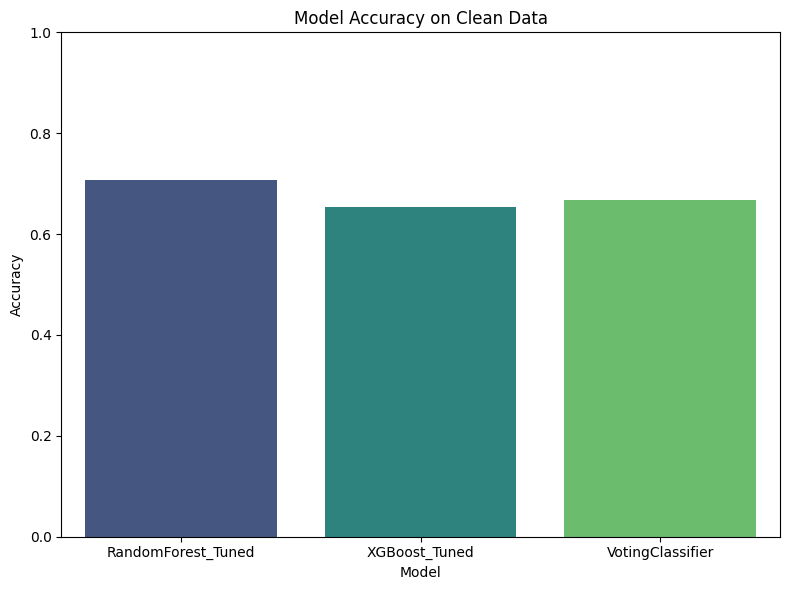

Accuracy Plot Saved to results\plots\clean_data_accuracy.png


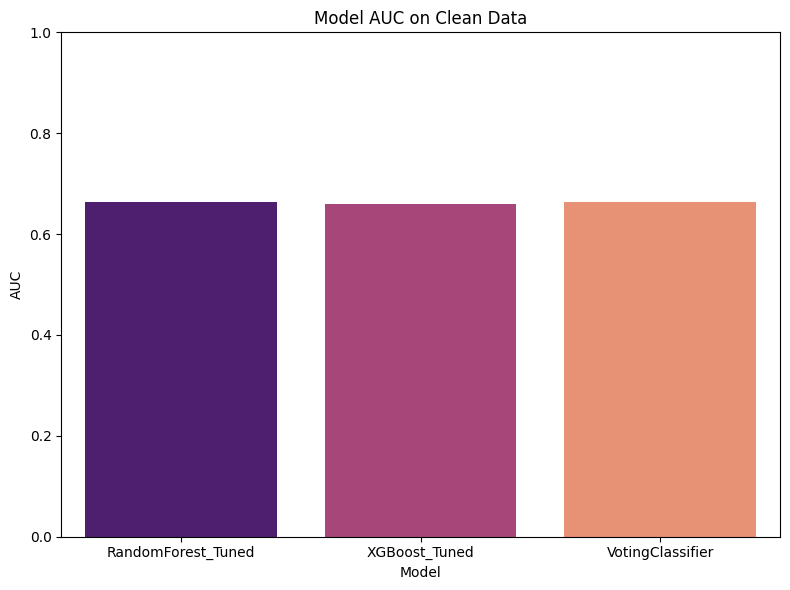

AUC Plot Saved to results\plots\clean_data_auc.png


In [ ]:
# Visualizing Model Performance

accuracy_plot_path = plots_dir / 'clean_data_accuracy.png'
auc_plot_path = plots_dir / 'clean_data_auc.png'

plt.figure(figsize=(8,6))
sns.barplot(x=clean_results_df.index, y='Accuracy', data=clean_results_df, palette='viridis')
plt.title('Model Accuracy on Clean Data')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(accuracy_plot_path)
plt.show()

print(f"Accuracy Plot Saved to {accuracy_plot_path}")
plt.figure(figsize=(8,6))
sns.barplot(x=clean_results_df.index, y='AUC', data=clean_results_df, palette='magma')
plt.title('Model AUC on Clean Data')
plt.ylabel('AUC')
plt.xlabel('Model')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(auc_plot_path)
plt.show()

print(f"AUC Plot Saved to {auc_plot_path}")



In [ ]:
# Evaluation on Test Set

final_models = {
    'RandomForest_Final': models['RandomForest_Tuned'],
    'VotingClassifier_Final': models['VotingClassifier']
}
test_results = {}
for model_name, model in final_models.items():
    print(f"Evaluating {model_name} on Test Set...")
    
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:,1]
    
    accuracy = accuracy_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_proba)
    f1 = f1_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)
    report = classification_report(y_test, y_test_pred, output_dict=True)
    
    test_results[model_name] = {
        'Accuracy': accuracy,
        'AUC': auc,
        'F1 Score': f1,
        'Confusion Matrix': cm,
        'Classification Report': report
    }
    
    print(f"{model_name} Evaluation Completed.\n")
# Saving Test Set Results

test_results_df = pd.DataFrame(test_results).T
test_results_df = test_results_df[['Accuracy', 'AUC', 'F1 Score']]

test_results_table_path = results_table_dir / 'test_data_results.csv'

test_results_df.to_csv(test_results_table_path, index=True)
print(f"Test Data Training Results Saved to {test_results_table_path}")


Evaluating RandomForest_Final on Test Set...
RandomForest_Final Evaluation Completed.

Evaluating VotingClassifier_Final on Test Set...
VotingClassifier_Final Evaluation Completed.

Test Data Training Results Saved to results\tables\test_data_results.csv


In [ ]:
#Save Test Classification Reports to JSON

import json

for model_name, metrics in test_results.items():
    report_json_path = classification_reports_dir / f'{model_name}_test_classification_report.json'
    
    with open(report_json_path, 'w') as f:
        json.dump(metrics['Classification Report'], f, indent=4)
    
    print(f"Test Classification Report for {model_name} saved to {report_json_path}")


Test Classification Report for RandomForest_Final saved to results\classification_reports\RandomForest_Final_test_classification_report.json
Test Classification Report for VotingClassifier_Final saved to results\classification_reports\VotingClassifier_Final_test_classification_report.json


In [ ]:
# Plot and Save Test Confusion Matrices

for model_name, metrics in test_results.items():
    cm = metrics['Confusion Matrix']
    
    cm_df = pd.DataFrame(cm, index=['Actual Bad', 'Actual Good'], columns=['Predicted Bad', 'Predicted Good'])
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Confusion Matrix - {model_name} (Test Set)')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()
    
    cm_plot_path = confusion_matrices_dir / f'{model_name}_test_confusion_matrix.png'
    
    plt.savefig(cm_plot_path)
    plt.close()
    
    print(f"Test Confusion Matrix for {model_name} saved to {cm_plot_path}")


Test Confusion Matrix for RandomForest_Final saved to results\confusion_matrices\RandomForest_Final_test_confusion_matrix.png
Test Confusion Matrix for VotingClassifier_Final saved to results\confusion_matrices\VotingClassifier_Final_test_confusion_matrix.png


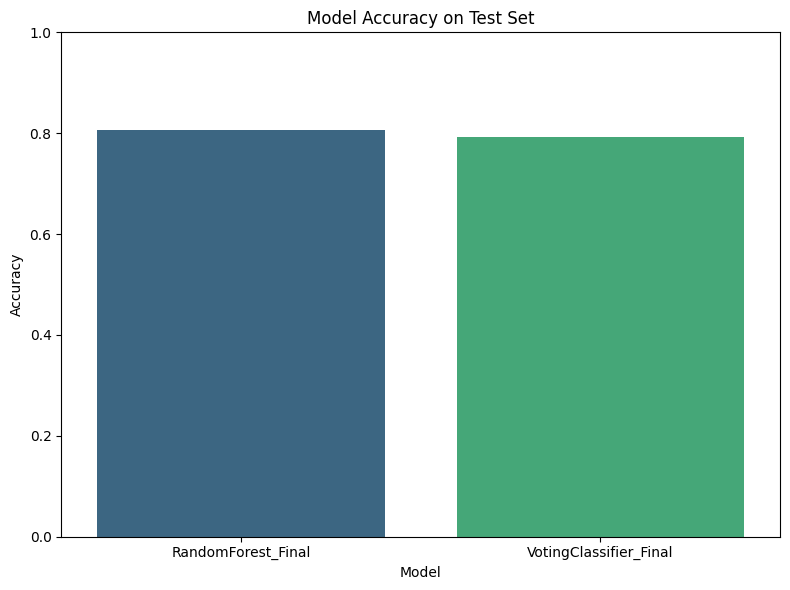

Test Accuracy Plot saved to results\plots\test_accuracy.png


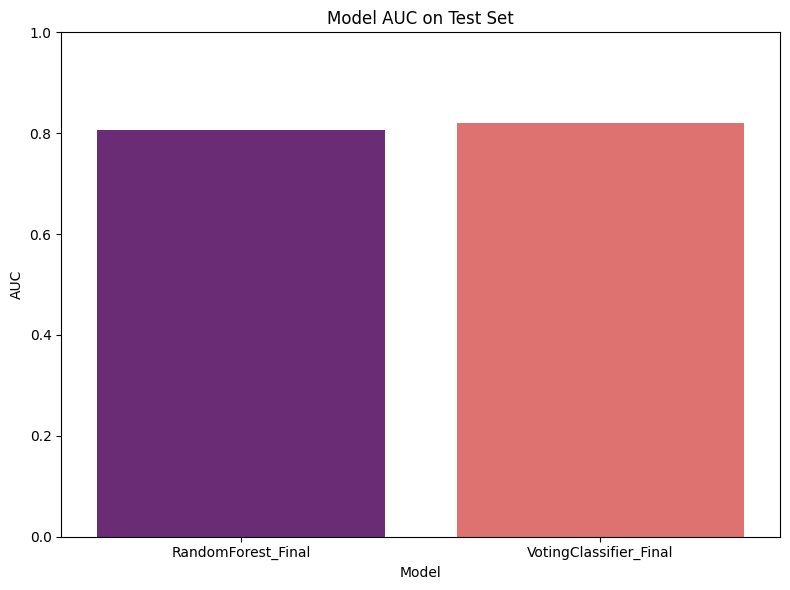

Test AUC Plot saved to results\plots\test_auc.png


In [ ]:
#Plot and Save Test Accuracy and AUC Bar Charts

test_accuracy_plot_path = plots_dir / 'test_accuracy.png'
test_auc_plot_path = plots_dir / 'test_auc.png'

# Plot Accuracy
plt.figure(figsize=(8,6))
sns.barplot(x=test_results_df.index, y='Accuracy', data=test_results_df, palette='viridis')
plt.title('Model Accuracy on Test Set')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(test_accuracy_plot_path)
plt.show()
print(f"Test Accuracy Plot saved to {test_accuracy_plot_path}")

# Plot AUC
plt.figure(figsize=(8,6))
sns.barplot(x=test_results_df.index, y='AUC', data=test_results_df, palette='magma')
plt.title('Model AUC on Test Set')
plt.ylabel('AUC')
plt.xlabel('Model')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(test_auc_plot_path)
plt.show()
print(f"Test AUC Plot saved to {test_auc_plot_path}")


In [ ]:
# Save Trained Models 
import joblib

models_base_dir = Path('./models/')
clean_models_dir = models_base_dir / 'clean_data'

clean_models_dir.mkdir(parents=True, exist_ok=True)

for model_name, model in models.items():
    model_filename = f"{model_name}.joblib"
    
    model_path = clean_models_dir / model_filename
    
    joblib.dump(model, model_path)
    
    print(f"Model {model_name} saved to {model_path}")


Model RandomForest_Tuned saved to models\clean_data\RandomForest_Tuned.joblib
Model XGBoost_Tuned saved to models\clean_data\XGBoost_Tuned.joblib
Model VotingClassifier saved to models\clean_data\VotingClassifier.joblib


## Data Poisoning
### -> Label flipping, feature manipulation, backdoor attacks, inj

In [20]:
# Import functions from data_poisoning.py
from data_poisoning import *

In [21]:
# Define necessary directories
results_dir = Path('./results/')
tables_dir = results_dir / 'tables'
classification_reports_dir = results_dir / 'classification_reports'
confusion_matrices_dir = results_dir / 'confusion_matrices'
plots_dir = results_dir / 'plots'
models_dir = Path('./models/clean_data/')  # Existing models saved here

# Create directories if they don't exist
for directory in [tables_dir, classification_reports_dir, confusion_matrices_dir, plots_dir, models_dir]:
    directory.mkdir(parents=True, exist_ok=True)


In [ ]:
# Data Poisoning Attacks


# Apply Label Flipping Poisoning
X_train_label_flipped, y_train_label_flipped = label_flipping(
    X_train_resampled,
    y_train_resampled,
    flip_rate=0.05,
    random_state=42
)

# Apply Feature Manipulation Poisoning
X_train_feature_manipulated, y_train_feature_manipulated = feature_manipulation(
    X_train_resampled,
    y_train_resampled,
    manipulation_rate=0.05,
    feature_range=(0, 1.5),
    random_state=42
)

# Inspect the feature list
print(f"Number of selected features before cleaning: {len(selected_feature_names)}")
print(f"Selected features: {selected_feature_names}")

if isinstance(selected_feature_names, np.ndarray):
    selected_feature_names = selected_feature_names.tolist()
    print("Converted selected_feature_names from NumPy array to list.")
else:
    print("selected_feature_names is already a list.")

# Check for duplicates
from collections import Counter

feature_counts = Counter(selected_feature_names)
duplicate_features = [feature for feature, count in feature_counts.items() if count > 1]

if duplicate_features:
    print(f"Duplicate features found: {duplicate_features}")
    selected_feature_names_unique = list(dict.fromkeys(selected_feature_names))
    print(f"Number of features after removing duplicates: {len(selected_feature_names_unique)}")
else:
    print("No duplicate features found.")
    selected_feature_names_unique = selected_feature_names.copy()

print(f"Number of selected unique features: {len(selected_feature_names_unique)}")
print(f"Number of columns in X_train_resampled: {X_train_resampled.shape[1]}")

if len(selected_feature_names_unique) != X_train_resampled.shape[1]:
    print("Mismatch between feature names and data columns. Adjusting accordingly.")
    extra_features = selected_feature_names_unique[X_train_resampled.shape[1]:]
    print(f"Extra features identified: {extra_features}")
    
    if 'credit_amount_per_month' in selected_feature_names_unique:
        selected_feature_names_unique.remove('credit_amount_per_month')
        print("Removed 'credit_amount_per_month' from feature list to align with data columns.")
    else:
        selected_feature_names_unique = selected_feature_names_unique[:X_train_resampled.shape[1]]
        print(f"Trimmed feature list to {len(selected_feature_names_unique)} features to match data columns.")
    
    selected_feature_names = selected_feature_names_unique
    print(f"Number of selected features after adjustment: {len(selected_feature_names)}")
else:
    selected_feature_names = selected_feature_names_unique
    print("Feature names and data columns are now aligned.")

trigger_feature_name = 'num__age_in_years' 

if trigger_feature_name in selected_feature_names:
    trigger_feature_idx = selected_feature_names.index(trigger_feature_name)
    print(f"Trigger feature '{trigger_feature_name}' found at index {trigger_feature_idx}.")
else:
    trigger_feature_idx = 0  
    print(f"Trigger feature '{trigger_feature_name}' not found. Using feature index {trigger_feature_idx} as default.")

num_features = X_train_resampled.shape[1]
if trigger_feature_idx >= num_features or trigger_feature_idx < 0:
    print(f"Invalid trigger_feature_idx: {trigger_feature_idx}. It must be between 0 and {num_features - 1}.")
    trigger_feature_idx = 0
    print(f"Adjusted trigger_feature_idx to {trigger_feature_idx}.")
else:
    print(f"Proceeding with trigger_feature_idx: {trigger_feature_idx}.")

X_train_backdoor, y_train_backdoor = backdoor_attack(
    X_train_resampled,
    y_train_resampled,
    trigger_feature_idx=trigger_feature_idx,
    trigger_value=999,  
    target_label=1,     
    injection_rate=0.05,
    random_state=42
)

# Apply Injection Attack Poisoning
X_train_injection, y_train_injection = injection_attack(
    X_train_resampled,
    y_train_resampled,
    injection_rate=0.05,
    random_state=42
)


Label Flipping: Flipped 49 out of 980 labels.
Feature Manipulation: Manipulated 49 out of 980 instances.
Number of selected features before cleaning: 31
Selected features: ['num__duration_in_month' 'num__credit_amount'
 'num__installment_rate_in_percentage_of_disposable_income'
 'num__age_in_years' 'cat__status_of_existing_checking_account_... < 0 DM'
 'cat__status_of_existing_checking_account_0 <= ... < 200 DM'
 'cat__status_of_existing_checking_account_no checking account'
 'cat__credit_history_all credits at this bank paid back duly'
 'cat__credit_history_critical account / other credits existing (not at this bank)'
 'cat__credit_history_existing credits paid back duly till now'
 'cat__credit_history_no credits taken / all credits paid back duly'
 'cat__purpose_radio/television'
 'cat__savings_account_bonds_.. >= 1000 DM'
 'cat__savings_account_bonds_100 <= ... < 500 DM'
 'cat__present_employment_since_.. >= 7 years'
 'cat__present_employment_since_unemployed'
 'cat__other_debtors__

In [ ]:
#Calculate scale_pos_weight for each poisoned dataset

# For Label Flipping
scale_pos_weight_label_flipped = len(y_train_label_flipped[y_train_label_flipped == 0]) / len(y_train_label_flipped[y_train_label_flipped == 1])

# For Feature Manipulation
scale_pos_weight_feature_manipulated = len(y_train_feature_manipulated[y_train_feature_manipulated == 0]) / len(y_train_feature_manipulated[y_train_feature_manipulated == 1])

# For Backdoor Attack
scale_pos_weight_backdoor = len(y_train_backdoor[y_train_backdoor == 0]) / len(y_train_backdoor[y_train_backdoor == 1])

# For Injection Attack
scale_pos_weight_injection = len(y_train_injection[y_train_injection == 0]) / len(y_train_injection[y_train_injection == 1])


In [40]:
# Retrain Models with Poisoned Data

# Retrain models for each poisoned dataset
models_label_flipped_poisoned = retrain_models(X_train_label_flipped, y_train_label_flipped, best_rf_params, best_xgb_params, scale_pos_weight_label_flipped)
models_feature_manipulated_poisoned = retrain_models(X_train_feature_manipulated, y_train_feature_manipulated, best_rf_params, best_xgb_params, scale_pos_weight_feature_manipulated)
models_backdoor_poisoned = retrain_models(X_train_backdoor, y_train_backdoor, best_rf_params, best_xgb_params, scale_pos_weight_backdoor)
models_injection_poisoned = retrain_models(X_train_injection, y_train_injection, best_rf_params, best_xgb_params, scale_pos_weight_injection)

# Evaluate Poisoned Models on Validation Set

poisoned_results_label_flipped = evaluate_models(models_label_flipped_poisoned, X_val, y_val, evaluation_name='LabelFlipping')
poisoned_results_feature_manipulated = evaluate_models(models_feature_manipulated_poisoned, X_val, y_val, evaluation_name='FeatureManipulation')
poisoned_results_backdoor = evaluate_models(models_backdoor_poisoned, X_val, y_val, evaluation_name='BackdoorAttack')
poisoned_results_injection = evaluate_models(models_injection_poisoned, X_val, y_val, evaluation_name='InjectionAttack')
#  Save Poisoned Evaluation Metrics and Reports

# Save evaluation metrics for all poisoning scenarios
for results, evaluation_type in zip(
    [poisoned_results_label_flipped, poisoned_results_feature_manipulated, poisoned_results_backdoor, poisoned_results_injection],
    ['LabelFlipping', 'FeatureManipulation', 'BackdoorAttack', 'InjectionAttack']
):
    save_evaluation_metrics(
        results,
        evaluation_type=evaluation_type,
        tables_dir=tables_dir,
        classification_reports_dir=classification_reports_dir,
        confusion_matrices_dir=confusion_matrices_dir
    )
# Visualize Poisoned Model Performance

# Plot Poisoned Results for all scenarios
for results, evaluation_type in zip(
    [poisoned_results_label_flipped, poisoned_results_feature_manipulated, poisoned_results_backdoor, poisoned_results_injection],
    ['LabelFlipping', 'FeatureManipulation', 'BackdoorAttack', 'InjectionAttack']
):
    plot_performance(results, evaluation_type=evaluation_type, plots_dir=plots_dir)

# Save Poisoned Models

# Save Label Flipping Poisoned Models
save_poisoned_models(models_label_flipped_poisoned, evaluation_type='LabelFlipping', models_dir=models_dir)

# Save Feature Manipulation Poisoned Models
save_poisoned_models(models_feature_manipulated_poisoned, evaluation_type='FeatureManipulation', models_dir=models_dir)

# Save Backdoor Attack Poisoned Models
save_poisoned_models(models_backdoor_poisoned, evaluation_type='BackdoorAttack', models_dir=models_dir)

# Save Injection Attack Poisoned Models
save_poisoned_models(models_injection_poisoned, evaluation_type='InjectionAttack', models_dir=models_dir)

# Evaluate Poisoned Models on Test Set
test_results_label_flipped = evaluate_models_test(models_label_flipped_poisoned, X_test, y_test, evaluation_name='LabelFlipping')
test_results_feature_manipulated = evaluate_models_test(models_feature_manipulated_poisoned, X_test, y_test, evaluation_name='FeatureManipulation')
test_results_backdoor = evaluate_models_test(models_backdoor_poisoned, X_test, y_test, evaluation_name='BackdoorAttack')
test_results_injection = evaluate_models_test(models_injection_poisoned, X_test, y_test, evaluation_name='InjectionAttack')

# Save Test Evaluation Metrics
save_test_evaluation_metrics(test_results_label_flipped, evaluation_type='LabelFlipping', tables_dir=tables_dir, classification_reports_dir=classification_reports_dir, confusion_matrices_dir=confusion_matrices_dir)
save_test_evaluation_metrics(test_results_feature_manipulated, evaluation_type='FeatureManipulation', tables_dir=tables_dir, classification_reports_dir=classification_reports_dir, confusion_matrices_dir=confusion_matrices_dir)
save_test_evaluation_metrics(test_results_backdoor, evaluation_type='BackdoorAttack', tables_dir=tables_dir, classification_reports_dir=classification_reports_dir, confusion_matrices_dir=confusion_matrices_dir)
save_test_evaluation_metrics(test_results_injection, evaluation_type='InjectionAttack', tables_dir=tables_dir, classification_reports_dir=classification_reports_dir, confusion_matrices_dir=confusion_matrices_dir)

# Visualize Test Performance Metrics
plot_test_performance(test_results_label_flipped, evaluation_type='LabelFlipping', plots_dir=plots_dir)
plot_test_performance(test_results_feature_manipulated, evaluation_type='FeatureManipulation', plots_dir=plots_dir)
plot_test_performance(test_results_backdoor, evaluation_type='BackdoorAttack', plots_dir=plots_dir)
plot_test_performance(test_results_injection, evaluation_type='InjectionAttack', plots_dir=plots_dir)


Training RandomForest_Poisoned...
RandomForest_Poisoned Training Completed.

Training XGBoost_Poisoned...
XGBoost_Poisoned Training Completed.

Training VotingClassifier_Poisoned...
VotingClassifier_Poisoned Training Completed.

Training RandomForest_Poisoned...
RandomForest_Poisoned Training Completed.

Training XGBoost_Poisoned...
XGBoost_Poisoned Training Completed.

Training VotingClassifier_Poisoned...
VotingClassifier_Poisoned Training Completed.

Training RandomForest_Poisoned...
RandomForest_Poisoned Training Completed.

Training XGBoost_Poisoned...
XGBoost_Poisoned Training Completed.

Training VotingClassifier_Poisoned...
VotingClassifier_Poisoned Training Completed.

Training RandomForest_Poisoned...
RandomForest_Poisoned Training Completed.

Training XGBoost_Poisoned...
XGBoost_Poisoned Training Completed.

Training VotingClassifier_Poisoned...
VotingClassifier_Poisoned Training Completed.

Evaluating RandomForest_Poisoned on Validation Set (LabelFlipping)...
RandomForest_P

## Defenses

In [ ]:
# Import functions from defenses.py
from src.defenses import (
    apply_isolation_forest,
    apply_lof,
    apply_autoencoder,
    retrain_models_with_params,
    evaluate_trained_models,
    save_evaluation_metrics,
    plot_roc_curves,
    plot_precision_recall_curves,
    plot_feature_importance,
    compile_comparative_results,
    save_comparative_results
)

root_dir = Path('.')
results_dir = root_dir / 'results'
tables_dir = results_dir / 'tables'
classification_reports_dir = results_dir / 'classification_reports'
confusion_matrices_dir = results_dir / 'confusion_matrices'
plots_dir = results_dir / 'plots'
models_dir = root_dir / 'models' / 'with_defenses'

for directory in [tables_dir, classification_reports_dir, confusion_matrices_dir, plots_dir, models_dir]:
    (directory / 'with_defenses').mkdir(parents=True, exist_ok=True)

# poisoning scenarios
scenarios = ['LabelFlipping', 'FeatureManipulation', 'BackdoorAttack', 'InjectionAttack']

# defense techniques
defense_techniques = ['IsolationForest', 'LOF', 'Autoencoder', 'IsolationForest_Autoencoder']


scenario_data = {
    'LabelFlipping': {
        'X_train_poisoned': X_train_label_flipped,  
        'y_train_poisoned': y_train_label_flipped,  
        'scale_pos_weight': scale_pos_weight_label_flipped  
    },
    'FeatureManipulation': {
        'X_train_poisoned': X_train_feature_manipulated, 
        'y_train_poisoned': y_train_feature_manipulated, 
        'scale_pos_weight': scale_pos_weight_feature_manipulated
    },
    'BackdoorAttack': {
        'X_train_poisoned': X_train_backdoor,
        'y_train_poisoned': y_train_backdoor, 
        'scale_pos_weight': scale_pos_weight_backdoor
    },
    'InjectionAttack': {
        'X_train_poisoned': X_train_injection, 
        'y_train_poisoned': y_train_injection, 
        'scale_pos_weight': scale_pos_weight_injection
    }
}

Scenario 'LabelFlipping' has matching X and y shapes: (980, 30), (980,)
Scenario 'FeatureManipulation' has matching X and y shapes: (980, 30), (980,)
Scenario 'BackdoorAttack' has matching X and y shapes: (1029, 30), (1029,)
Scenario 'InjectionAttack' has matching X and y shapes: (1029, 30), (1029,)


In [ ]:
# Function to save trained models
def save_trained_models(models, scenario, defense, models_dir):
    for model_name, model in models.items():
        # Define the filename for the model
        model_filename = f"{model_name}_{defense}.joblib"
        
        # Define the full path to save the model
        scenario_defense_dir = models_dir / f"{scenario}_{defense}"
        scenario_defense_dir.mkdir(parents=True, exist_ok=True)
        model_path = scenario_defense_dir / model_filename
        
        # Save the model using Joblib
        joblib.dump(model, model_path)
        
        print(f"Model {model_name} saved to {model_path}")

if 'clean_results' not in locals():
    print("\n=== Evaluating Models on Clean Data ===")
    models_clean = {
        'RandomForest_Clean': best_rf, 
        'XGBoost_Clean': best_xgb,     
        'VotingClassifier_Clean': models['VotingClassifier']
    }
    
    clean_results = evaluate_trained_models(
        models_clean,
        X_val,
        y_val,
        evaluation_name='Clean_Data'
    )
    
    save_evaluation_metrics(
        clean_results,
        evaluation_type='Clean_Data',
        tables_dir=tables_dir,
        classification_reports_dir=classification_reports_dir,
        confusion_matrices_dir=confusion_matrices_dir
    )
    
    print("Clean data evaluation metrics and reports saved.")

# Iterate through each scenario and defense technique
for scenario in scenarios:
    print(f"\n=== Processing Scenario: {scenario} ===")
    
    # Retrieve data for the scenario
    X_train_poisoned = scenario_data[scenario]['X_train_poisoned']
    y_train_poisoned = scenario_data[scenario]['y_train_poisoned']
    scale_pos_weight = scenario_data[scenario]['scale_pos_weight']
    
    for defense in defense_techniques:
        print(f"\n--- Applying Defense: {defense} ---")
        
        # Create directory for scenario-defense combination
        scenario_defense_dir = tables_dir / f"with_defenses/{scenario}_{defense}"
        scenario_defense_dir.mkdir(parents=True, exist_ok=True)
        
        try:
            # Apply defense
            if defense == 'IsolationForest':
                X_clean, y_clean = apply_isolation_forest(
                    X_train_poisoned, 
                    y_train_poisoned,
                    contamination=0.05, 
                    random_state=42
                )
            elif defense == 'LOF':
                X_clean, y_clean = apply_lof(
                    X_train_poisoned, 
                    y_train_poisoned,
                    contamination=0.05, 
                    n_neighbors=20
                )
            elif defense == 'Autoencoder':
                X_clean, y_clean = apply_autoencoder(
                    X_train_poisoned, 
                    y_train_poisoned,
                    encoding_dim=14, 
                    epochs=50, 
                    batch_size=32, 
                    contamination=0.05
                )
            elif defense == 'IsolationForest_Autoencoder':
                X_intermediate, y_intermediate = apply_isolation_forest(
                    X_train_poisoned, 
                    y_train_poisoned,
                    contamination=0.05, 
                    random_state=42
                )
                X_clean, y_clean = apply_autoencoder(
                    X_intermediate, 
                    y_intermediate,
                    encoding_dim=14, 
                    epochs=50, 
                    batch_size=32, 
                    contamination=0.05
                )
            else:
                raise ValueError(f"Unknown defense technique: {defense}")
            
            print(f"Defense {defense} applied successfully.")
        
        except Exception as e:
            print(f"Error applying {defense} on scenario {scenario}: {e}")
            continue
        
        # Retrain models on the cleaned dataset
        models_cleaned = retrain_models_with_params(
            X_clean, 
            y_clean, 
            best_rf_params, 
            best_xgb_params, 
            scale_pos_weight
        )
        
        # Evaluate models and save results
        results_cleaned = evaluate_trained_models(
            models_cleaned, 
            X_val, 
            y_val, 
            evaluation_name=f'{scenario}_{defense}'
        )
        
        # Save evaluation metrics and reports in the correct folder
        save_evaluation_metrics(
            results_cleaned,
            evaluation_type=f'{scenario}_{defense}',
            tables_dir=scenario_defense_dir,  # Use specific scenario-defense directory
            classification_reports_dir=scenario_defense_dir,
            confusion_matrices_dir=scenario_defense_dir
        )
        
        # Save trained models in the correct folder
        save_trained_models(models_cleaned, scenario, defense, scenario_defense_dir)
        
        # Save performance plots (ROC, PR curves, etc.) in the correct folder
        roc_plot_path = scenario_defense_dir / f"{scenario}_{defense}_ROC_Curves.png"
        pr_plot_path = scenario_defense_dir / f"{scenario}_{defense}_PrecisionRecall_Curves.png"
        plot_roc_curves(models_cleaned, X_val, y_val, roc_plot_path, title=f'ROC Curves - {scenario} + {defense}')
        plot_precision_recall_curves(models_cleaned, X_val, y_val, pr_plot_path, title=f'Precision-Recall Curves - {scenario} + {defense}')



=== Processing Scenario: LabelFlipping ===

--- Applying Defense: IsolationForest ---
Isolation Forest detected 49 anomalies out of 980 instances.
Defense IsolationForest applied successfully.
Evaluating RandomForest on LabelFlipping_IsolationForest scenario...
RandomForest - Accuracy: 0.7133, AUC: 0.6839, F1 Score: 0.8018

Evaluating XGBoost on LabelFlipping_IsolationForest scenario...
XGBoost - Accuracy: 0.6867, AUC: 0.6770, F1 Score: 0.7814

Summary metrics for LabelFlipping_IsolationForest saved to results\tables\with_defenses\LabelFlipping_IsolationForest\LabelFlipping_IsolationForest_results.csv
Classification report for RandomForest saved to results\tables\with_defenses\LabelFlipping_IsolationForest\RandomForest_LabelFlipping_IsolationForest_classification_report.json
Confusion matrix for RandomForest saved to results\tables\with_defenses\LabelFlipping_IsolationForest\RandomForest_LabelFlipping_IsolationForest_confusion_matrix.png
Classification report for XGBoost saved to resu

In [ ]:
# combine all results
import glob

with_defenses_tables_dir = tables_dir / 'with_defenses'

comparative_files = glob.glob(str(with_defenses_tables_dir / '*.csv'))

comparative_dfs = []

expected_columns = ['Accuracy', 'AUC', 'F1 Score', 'Scenario_Defense']

for file in comparative_files:
    df = pd.read_csv(file)
    
    print(f"Processing file: {file}, Columns: {list(df.columns)}")
    
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    if 'Scenario_Defense' not in df.columns:
        filename = Path(file).stem  
        scenario_defense = filename.replace('_results', '')  
        df['Scenario_Defense'] = scenario_defense

    if 'Scenario' in df.columns:
        df.rename(columns={'Scenario': 'Scenario_Defense'}, inplace=True)

    for col in expected_columns:
        if col not in df.columns:
            df[col] = None

    df = df[expected_columns]

    df.reset_index(drop=True, inplace=True)

    comparative_dfs.append(df)

for i, df in enumerate(comparative_dfs):
    print(f"DataFrame {i} shape: {df.shape}, Columns: {df.columns}")

cleaned_dfs = []
for df in comparative_dfs:
    if df.columns.duplicated().any():
        df = df.loc[:, ~df.columns.duplicated()]
    cleaned_dfs.append(df)

try:
    final_comparative_df = pd.concat(cleaned_dfs, ignore_index=True)
except Exception as e:
    print(f"Error during concatenation: {e}")
    raise

final_results_csv = with_defenses_tables_dir / 'results.csv'
final_comparative_df.to_csv(final_results_csv, index=False)
print(f"All Project Results Aggregated and Saved to {final_results_csv}")
display(final_comparative_df.head())


Processing file: results\tables\with_defenses\LabelFlipping_IsolationForest_results.csv, Columns: ['Unnamed: 0', 'Accuracy', 'AUC', 'F1 Score']
Processing file: results\tables\with_defenses\comparative_results_LabelFlipping_IsolationForest.csv, Columns: ['Accuracy', 'AUC', 'F1 Score', 'Scenario']
Processing file: results\tables\with_defenses\LabelFlipping_LOF_results.csv, Columns: ['Unnamed: 0', 'Accuracy', 'AUC', 'F1 Score']
Processing file: results\tables\with_defenses\comparative_results_LabelFlipping_LOF.csv, Columns: ['Accuracy', 'AUC', 'F1 Score', 'Scenario']
Processing file: results\tables\with_defenses\LabelFlipping_Autoencoder_results.csv, Columns: ['Unnamed: 0', 'Accuracy', 'AUC', 'F1 Score']
Processing file: results\tables\with_defenses\comparative_results_LabelFlipping_Autoencoder.csv, Columns: ['Accuracy', 'AUC', 'F1 Score', 'Scenario']
Processing file: results\tables\with_defenses\LabelFlipping_IsolationForest_Autoencoder_results.csv, Columns: ['Unnamed: 0', 'Accuracy', '

,Accuracy,AUC,F1 Score,Scenario_Defense
0,0.700000,0.706032,0.796380,LabelFlipping_IsolationForest
1,0.660000,0.624339,0.764977,LabelFlipping_IsolationForest
2,0.706667,0.724127,0.807018,Clean Data
3,0.666667,0.609947,0.772727,Clean Data
4,0.700000,0.669418,0.798206,Clean Data
